# EXERCICIO 3

Proponha uma arquitetura com dois níveis no qual o primeiro nível é usado para classificar “padrões fáceis”. Já o segundo nível só é usado para classificar “padrões difíceis”. Explique como será feita a classificação do padrão em fácil ou em difícil. Qual será o modelo de classificação usado para o primeiro nível e para o segundo nível? Possíveis modelo: monolítico, combinação estática, DCE ou DES. Justifique.

## Compare a arquitetura proposta com dois métodos de DCS e dois métodos de DES. 
- Bagging para gerar o pool com 100 Perceptrons; 
- 10-fold cross-validation; 
- Utilizar as medidas: taxa de acerto, AUC, g-mean e f-measure; 

## Descrição das Bases de Dados:

- Os dois conjuntos de dados escolhidos são chamados de kc1 e kc2, ambos com dados sobre detecção de falha em softwares. As bases escolhidas são binárias e são desbalanceadas, ou seja, possuem apenas duas classes em que a quantidade de exemplos de uma é maior do que a outra.

- A base kc1 possui 2109 observações, sendo 326 para a classe com falhas e 1783 para a classe que não tem falhas. Cada observação possui 22 atributos. Já a base kc2 possui 522 observações, sendo 105 para classe com falhas e 415 para a classe com observações perfeitas. Semelhante a base anterior, cada observação da classe kc2 possui 22 atributos. 

In [3]:
# importando o script que importa os resultados e gera os gráficos
from analise03 import *

In [4]:
# Definindo as metricas que serão utilizadas na analise
metricas = ['acuracy', 'auc', 'fmeasure', 'gmean']

# Definindo os datasets usados na avaliação
data = ['kc1', 'kc2']

## 1. Arquitetura de dois níveis:

A arquitetura proposta tem como objetivo dividir a etapa de classificação em dois níveis, em que o primeiro nível é responsável em classificar padrões fáceis, enquanto que o segundo nível é responsabilizado em classificar padrões difíceis. Essa arquitetura possui dois procedimentos, sendo um em relação a etapa de treinamento da arquitetura e o outro sobre a etapa de classificação de uma observação consultada.

### 1.1. Etapa de treinamento

A etapa de treinamento da arquitetura está ilustrada na Figura 1. Nesse diagrama o procedimento de treinamento é dividido em três etapas. A primeira etapa consiste em treinar o classificador de instâncias fáceis. Para esta etapa escolhemos como classificador o algoritmo k-Nearest-Neighbors (kNN). Este classificador foi escolhido devido a sua capacidade de classificar bem regiões que possuem muitas instâncias da mesma classe. Para o kNN classificar um novo exemplo, ele verifica a vizinhança do exemplo consultado, a classe atribuída a essa observação é aquela que possui maior quantidade na vizinhança. Esse procedimento torna o kNN um excelente classificador para instâncias fáceis.

Então, o procedimento da primeira etapa consiste em receber um conjunto de dados $ T= (x_{i}, y_{i})^m_{i=1} $, em que $x_{i}$ representa os padrões para treinamento, $y_{i}$ as respectivas classes dos exemplos e m a quantidade de exemplos contidos no conjunto de dados T. Com esses dados um modelo de kNN é treinado, em que esse modelo recebe como parâmetro o tamanho da vizinhança para classificação. Dado que foi treinado um modelo capaz de responder a instâncias fáceis, inicia-se o processo de definir o que é fácil para o kNN e o que é difícil de ser classificado. Para saber isso, utilizamos o kNN para computar a classificação de todos os padrões $x_{i}$ do conjunto de dados T, obtendo assim um vetor numérico $\hat{y}_{i}$' de tamanho m que representa todas as classificações do kNN para o conjunto de treinamento. Após isso salvamos todos os padrões $x_{i}$ que tiveram suas classificações erradas pelo kNN $(y_{i} \neq \hat{y}_{i})$. 

![](arquivos_lista03/procedimento%20metodo.png)

Após a primeira etapa, inicia-se a etapa de seleção de instâncias difíceis. O objetivo dessa etapa é selecionar as informações mais difíceis de serem classificadas para treinar um classificador especialista nessa situação. Para definir o que é uma instância difícil e fácil, utilizamos a métrica k-Disagreeing-Neighbors (kDN), dada pela seguinte equação:

$$
kDN(x_{i},T,k)=  \frac{(|x_j | x_j \in kNN(x_{i},T,k) \sim y_{j} \neq  y_{i} |)}{k}
$$


Em que k, representa o tamanho da vizinhança do exemplo consultado. A métrica kDN avalia a proporção de exemplos na vizinhança da observação consultada que compartilham a mesma classe. Essa métrica mede a dificuldade dos exemplos entre o intervalo de [0, 1], em que valores próximos a 1 indicam que a observação é muito difícil de ser classificada, e valores próximos a 0 indicam que é uma observação fácil de ser classificada.  Logo para cada observação existente no conjunto de dados T calcula-se o seu kDN, resultando assim em um vetor numérico $H = {h_{i}}^{m}_{i=1}$ que possui o mesmo comprimento de T.


Outro ponto importante a ser destacado no processo de seleção das instâncias difíceis é definir um limiar para separar o que é fácil de difícil. Uma das possibilidades para isso seria definir de maneira manual, porém o grande problema é que esse parâmetro precisa ser ajustado para cada conjunto de dados experimentado. Pensando nessa circunstância, propomos um método que define automaticamente este limiar, em que esse limiar é calculado baseado no grau de dificuldade das instâncias que foram classificadas erradas pelo kNN. Este método é chamado de grau de dificuldade da região, dado pelo algoritmo 1.

![](http://localhost:8888/view/MCS/Lista03/arquivos_lista03/algoritmo.png)

No algoritmo 1, recebe-se como entrada: x_query a instância a ser consultada; H as dificuldades de todas as instâncias de treinamento; T o conjunto de treinamento; e k o tamanho da vizinhança. Dado isso, o algoritmo inicia com o cálculo dos k vizinhos mais próximos da observação consultada. Com os índices desses vizinhos, verificamos em H as suas dificuldades e os salvamos em um vetor numérico chamado de “dificuldades” na linha 3. Por fim, retornamos a dificuldade mínima dos vizinhos da instância consultada. A intenção desse método é verificar o grau de dificuldade mínimo da região que vizinha a instância consultada. 
	Na arquitetura proposta esse processo é repetido para todas as instâncias que foram classificadas de forma errada para o kNN. Então, dado um vetor $X = {x_{i}}^{p}_{i=1}$ que representa as instâncias que foram classificadas erradas, o limiar é dado por:
    
$$
\delta = \frac{\sum_{p}^{i}DificuldadeRegiao(x_{i}, H, T, k)}{p}
$$


Com a definição do limiar, o passo final dessa etapa consiste em separar as instâncias fáceis das difíceis. Logo, salva-se em outra base chamada T_hard todas as instâncias que têm um kDN maior que o limiar δ. Esse processo é representado pela seguinte equação:

$$
\forall h_{i} > \delta, (x_{i}, y_{i})
$$

Por fim, temos a etapa de criação do modelo especialista em instâncias difíceis.  Dado um conjunto de instâncias difíceis representado por: $T_{hard} = (x_{i}, y_{i})^{n}_{i=1}$, geramos um pool com L perceptrons por meio do Bagging. O Bagging foi escolhido por ser uma técnica de geração adequada para conjuntos de dados de tamanho pequeno. Além disso possibilita a geração de diferentes modelos de classificação devido a diferentes amostras que são geradas para o treinamento dos classificadores. O perceptron foi utilizado para tornar a comparação justa com os outros modelos experimentados nessa lista.


## 1.2. Etapa de Classificação

A segunda etapa da arquitetura proposta consiste em realizar as classificações para as instâncias de teste. Na Figura 3 apresentamos por meio de um diagrama o procedimento de classificação da arquitetura. O diagrama divide o procedimento em duas etapas, a etapa de verificação de dificuldade da instância de teste, e a etapa da escolha do classificador mais adequado para a observação.

A etapa de verificação de dificuldade consiste na análise da região de competência da instância de teste por meio do algoritmo ilustrado na Figura 2. Como o algoritmo proposto não depende do rótulo da observação consultada, torna-se possível avaliar apenas por meio da sua vizinhança o nível de dificuldade da observação. Logo, se a vizinhança da observação for simples, utilizamos o algoritmo kNN para dar o rótulo do exemplo. Por outro lado, se a observação se apresentar em uma região difícil, utilizamos um método de DES chamado de KNORA-U.

O KNORA-U seleciona todos os classificadores que acertam pelo menos uma observação da região de competência. Após essa seleção os votos dos classificadores são ponderados pela quantidade de observações que eles acertam na região de competência. Essa técnica foi escolhida para classificar instâncias difíceis pelo seguinte motivo: o uso de várias opiniões pode favorecer a classificação de instâncias difíceis dado que existem diversos especialistas treinados para lidar com esse problema. Dessa maneira reduz-se a probabilidade de se basear na opinião de um único classificador, que por sua vez é muito dependente do seu ajuste no processo de treinamento.

![](http://localhost:8888/view/MCS/Lista03/arquivos_lista03/teste.png)

Portanto, com essa abordagem buscamos minimizar os erros causados pelas instâncias difíceis já que se utiliza um pool de classificadores especialistas nessa região. 

## 2. Comparação com Técnicas de DES



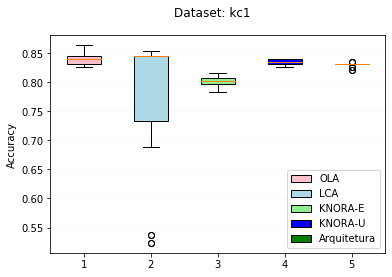

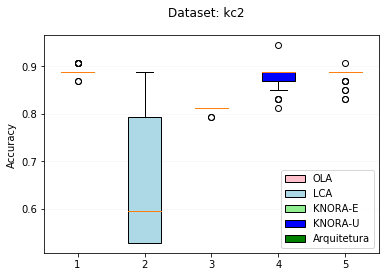

In [5]:
# Figura 4. Acurácia dos modelos para os conjuntos de dados: kc1 e kc2.
gerar_boxplot_geral(data[0], metricas[0])
gerar_boxplot_geral(data[1], metricas[0])

Ao observar a Figura 4, percebe-se que o método de DS que apresentou o melhor desempenho considerando os dois conjuntos de dados foi o OLA. Em oposição a isso os métodos com pior desempenho foram KNORA-E e LCA. As primeiras análises que obtemos em relação a isso é que para esses conjuntos de dados, técnicas que focam na capacidade de um classificador tendem a ter melhores desempenhos. Isso pode ser visto pelo OLA que seleciona o melhor classificador para a região de competência. Da mesma maneira o KNORA-U que pondera os votos de acordo com o desempenho de cada classificador para a região de competência. 

Ainda sobre essa métrica, podemos observar que a abordagem proposta reduziu significativamente o desvio padrão do seu desempenho quando comparado com todos os outros modelos. No entanto, em nenhum dos dois conjuntos de dados ele obteve o melhor desempenho. Ainda nesse sentido, pode-se observar que para o conjunto de dados kc1 ele obteve desempenho inferior as técnicas OLA e KNORA-U, mas no conjunto de dados kc2 ele obteve melhor desempenho que o KNORA-U e foi igual estatisticamente ao OLA.


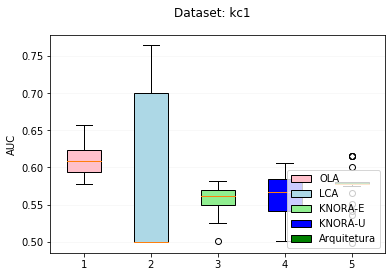

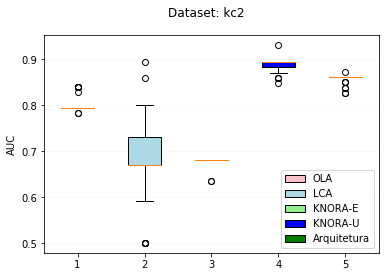

In [6]:
#Figura 5. AUC dos modelos para os conjuntos de dados: kc1 e kc2.
gerar_boxplot_geral(data[0], metricas[1])
gerar_boxplot_geral(data[1], metricas[1])

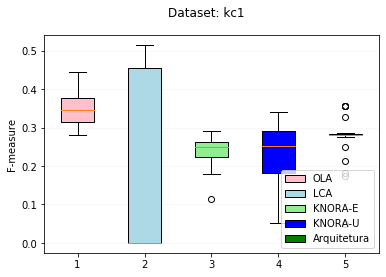

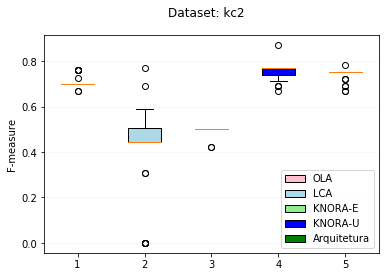

In [10]:
#Figura 6. F-measure dos modelos para os conjuntos de dados: kc1 e kc2.
gerar_boxplot_geral(data[0], metricas[2])
gerar_boxplot_geral(data[1], metricas[2])

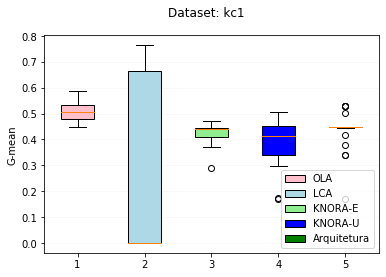

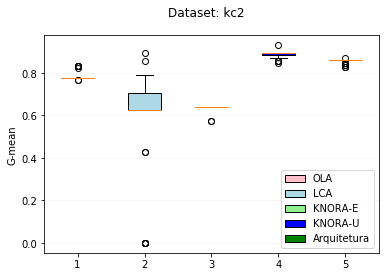

In [14]:
#Figura 7. G-mean dos modelos para os conjuntos de dados: kc1 e kc2.
gerar_boxplot_geral(data[0], metricas[3])
gerar_boxplot_geral(data[1], metricas[3])

Em relação as métricas AUC, F-measure e G-mean, observa-se que o comportamento de todas as técnicas se repetem, independentemente da métrica. Nessa discussão verificamos que para o conjunto de dados kc1, o algoritmo OLA obteve inquestionavelmente o melhor desempenho. Considerando a mediana e o desvio padrão, destaca-se em segundo melhor desempenho a arquitetura proposta. Com isso concluímos que para o conjunto de dados kc1 a melhor abordagem a ser utilizada considerando todas as métricas é o OLA, tendo como candidatos competitivos o KNORA-U, apenas para a acurácia, e a arquitetura proposta, considerando todas as métricas.

Em relação ao conjunto de dados kc2, observa-se que o algoritmo KNORA-U obteve os melhores desempenhos considerando as métricas AUC, F-measure e G-mean. Em seguida o algoritmo que mais se aproxima desses resultados é a arquitetura proposta. Com isso concluímos que o uso ponderado de várias opiniões produz melhor qualidade das classificações, dado o bom desempenho nas métricas AUC e F-measure. Além disso, favorecem a classificação de ambas as classes, dado que o conjunto de dados kc2 é desbalanceado.

# Conclusão

Este relatório teve como objetivo apresentar os resultados obtidos para a lista 03 da disciplina de Sistemas de Múltiplos Classificadores. Para esta lista de exercícios foi proposto uma arquitetura de dois níveis de classificação, em que a primeira busca lidar com instâncias fáceis utilizando o algoritmo kNN, e o segundo busca lidar com instâncias difíceis utilizando o KNORA-U para um pool com 100 perceptrons gerados por Bagging. 

Os principais resultados mostram que para o conjunto de dados kc1, o melhor algoritmo foi o OLA, apresentando diferença significativa de desempenho dos outros modelos considerando todas as métricas. 

Por outro lado, para o conjunto de dados kc2, o algoritmo com melhor desempenho considerando todas as métricas foi o algoritmo KNORA-U, também apresentando diferença significativa de desempenho em relação aos outros modelos. 

Ainda sobre esses resultados, destaca-se a arquitetura proposta que independentemente do conjunto de dados utilizado e da métrica avaliada se mostrou bastante competitivo com o primeiro colocado. Desempenho esse que não ocorreu com mais nenhum outro algoritmo, pois sempre variavam muito de acordo com a situação.

Como possíveis trabalhos futuros, destaca-se a investigação de métodos que possam caracterizar melhor o grau de dificuldade de uma região de competência e não apenas para a instância de consulta. A vantagem disso é que não se necessita do rótulo da instância consultada.